Dataset Docs:

Lisensi: https://creativecommons.org/licenses/by-sa/4.0/
versi: 1.0 (Agt 2018)


Penjelasan Label
0: sms normal
1: fraud atau penipuan
2: promo

Catatan:
Data dibersihkan dari  informasi pribadi. Nama diganti dengan "nama1"

Jumlah data: 1143
Jumlah per kelas:
0: 569
1: 335
2: 239

Cara mensitasi:
"Rahmi, F. and Wibisono, Y.  (2016). Aplikasi SMS Spam Filtering pada Android menggunakan Naive Bayes, Unpublished manuscript."

Menerima sumbangan data spam SMS, silakan kontak yudi@upi.edu

In [ ]:
from google.colab import drive;
from sklearn.model_selection import train_test_split;

import pandas;

In [ ]:
drive.mount('/content/drive');

base_path = "/content/drive/MyDrive/Collab Dataset/dataset_sms/";
file_name = "dataset_sms_spam_v1.csv";

Mounted at /content/drive


# Dataset Pre-Processing

In [ ]:
dataframe = pandas.read_csv(base_path + file_name);

dataframe.shape

(1143, 2)

In [ ]:
dataframe.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


This part is data splitting and performing One-Hot Encoding for `label`

The splits will be 70 : 15 : 15 for train : test : val

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words = 1000, oov_token = "<OOV>");
tokenizer.fit_on_texts(dataframe["Teks"]);

word_index = tokenizer.word_index

In [ ]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(dataframe["Teks"])
dataframe["Teks"] = pad_sequences(sequences, maxlen = 1000, padding = "post", truncating = "post")

In [ ]:
dataframe["Teks"].shape, len(sequences)

sequences[0]

[34,
 67,
 26,
 98,
 114,
 267,
 2,
 348,
 109,
 305,
 78,
 209,
 50,
 210,
 121,
 349,
 17,
 209,
 146,
 226,
 822,
 381,
 171,
 22,
 2,
 63,
 72,
 496,
 55,
 172]

In [ ]:
feature_train, feature_test, label_train, label_test = train_test_split(
    dataframe.drop(columns = ["label"]),
    dataframe["label"],
    train_size=0.7,
    random_state = 42
);

feature_test, feature_val, label_test, label_val = train_test_split(
    feature_test,
    label_test,
    train_size=0.5,
    random_state = 42
);

label_train = pandas.get_dummies(label_train, prefix = "label");
label_test = pandas.get_dummies(label_test, prefix = "label");
label_val = pandas.get_dummies(label_val, prefix = "label");

In [ ]:
import tensorflow;
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Embedding, SimpleRNN, BatchNormalization, LSTM, Bidirectional, GRU;

import matplotlib.pyplot as plt;

from tensorflow.keras.utils import plot_model;
from tensorflow.keras.callbacks import EarlyStopping;


In [ ]:
# Arsitektur model LSTM dengan Embedding
# Belajar bikin-run through model-model RNN-based. 
# Hasilnya bagusan yang ini jadi pilih yang ini
# 
# Modelnya belum di tuning apa-apa jadi masih overfitting. 
#
# He He He :3
class LSTMModel:
  def __init__(self):

    # Ekspektasi panjang token 1000 per baris. Panjang ye~
    # Waktu itu males ngitung berapa panjang maksimal SMS di Indonesia.
    self.input = Input(shape=(1000,))

    # Implementasi Embedding.
    self.embedding = Embedding(
       1000, # Jumlah vocabulary 
       1000, # Output buat Forward Propagation si Embedding. Dense.
       input_length = 1000 # Ini ngikutin dari Input. Kalau di Input 1000, disini mesti 1000
    );

    # LSTM. Pardon me namanya masih rnn. 
    # Yang support GPU, kalau setting activationnya tanh atau relu. Hati-hati.
    # 128 itu jumlah neuron buat LSTM-nya. 
    self.rnn = LSTM(128, activation = "tanh", recurrent_initializer = 'glorot_uniform');
    
    # Implementasi Batch Normalization
    self.bn1 = BatchNormalization();

    # Ini hidden layer untuk bantu mencerdaskan model. Dikasi activation ReLU
    self.dense1 = Dense(6, activation = "relu");

    # Penjelasan Label
    # 0: sms normal
    # 1: fraud atau penipuan
    # 2: promo
    # 
    # Data label nya sudah di One-Hot Encoded.
    self.output = Dense(3, activation = "softmax");

  # Early stopping after loss are not improved for some epochs
  def _callback_early_stopping(self):
      early_stopping_tolerance = 50; # Di set 50 biar kalo 50 epoch ga improve val loss nya, distop
      return EarlyStopping(
          monitor = "val_loss",
          patience = early_stopping_tolerance,
          restore_best_weights = True
      );

  def fitting(self):
      # Build model
      model = Sequential();

      model.add(self.input);

      model.add(self.embedding);
      model.add(self.rnn);

      model.add(self.bn1);

      model.add(self.dense1);
      model.add(self.output);

      model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]);
      model.summary();

      # Print model architecturenya
      plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);

      # Training
      history = model.fit(
          feature_train, # Datanya ada diatas
          label_train, # Datanya ada diatas
          epochs = 300, # LSTM berat. Run di Collab pakai L4 GPU.
          batch_size = 64, # Kalo gaada mesinnya, kecilin ini ke 16.
          validation_data = (feature_val, label_val), # Datanya ada diatas
          callbacks = [self._callback_early_stopping()] # Implementasi callback
      );

      # Plot training history
      plt.plot(history.history['loss'], label='Training Loss');
      plt.plot(history.history['val_loss'], label='Validation Loss');
      plt.xlabel('Epoch');
      plt.ylabel('Loss');
      plt.legend();
      plt.show();

      return model;

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1000, 1000)        1000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               578048    
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 6)                 774       
                                                                 
 dense_17 (Dense)            (None, 3)                 21        
                                                                 
Total params: 1579355 (6.02 MB)
Trainable params: 1579099 (6.02 MB)
Non-trainable params: 256 (1.00 KB)
________________

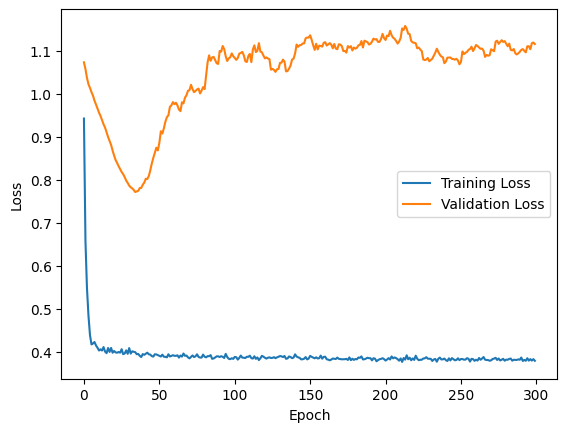

6/6 [==============================] - 0s 4ms/step - loss: 1.1038 - accuracy: 0.7076
Test accuracy LSTM: 0.707602322101593


In [ ]:
lstm = LSTMModel();
model = lstm.fitting();

test_loss, test_acc = model.evaluate(feature_test, label_test)
print(f'Test accuracy LSTM: {test_acc}')